In [1]:
import numpy as np

# Define the file path and data type
file_path = 'Test_Data/60m_business_field_test/rx_data_raw_SN03_UHF240129T192608'  # Replace with the actual file path
dtype = np.complex64  # 32-bit complex data type

# Calculate the number of elements to read for 1 GB of data
bytes_to_read = 8 * 1024 * 1024 * 1024  # 1 GB in bytes
complex_size = 64
elements_to_read = 1 * bytes_to_read // complex_size

# Read the first gigabyte of data
data = np.fromfile(file_path, dtype=dtype, count=elements_to_read)

# If you want to reshape the data into a 1D array of complex numbers, you can do:
data = data.reshape(-1)

len(data) * complex_size / 8, data


(1073741824.0,
 array([ 0.015625 +0.j       ,  0.015625 +0.j       ,
         0.015625 +0.j       , ...,  0.265625 -0.2734375j,
        -0.0390625+0.09375j  ,  0.3359375+0.0234375j], dtype=complex64))

In [2]:
import matplotlib.pyplot as plt
import math
from scipy.signal import butter, lfilter, freqz

# Calculate the time values based on the sample rate (500 ksps)
sample_rate = 500e3  # 500 ksps
time = np.arange(len(data)) / sample_rate
fsk_deviation = 1.1e3
symbol_rate = 1e3 # symbols per second
samples_per_symbol = sample_rate / symbol_rate

# Multiply by a sine wave if the input is too close to 0 frequency
# data = data * (np.sin(2 * np.pi * time * 5e3) - 1j * np.cos(2 * np.pi * time * 5e3))

# Run the data through a low pass filter data
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

cutoff = 10e3 # Hz
filtered_data = butter_lowpass_filter(data, cutoff, sample_rate, 5)

# Demodulate the data
# Option 1 uses proper Quadrature demodulation, 
#   numeric version of the imaginary part of the derivative of the natural log of the input
#demodulated_data = 0.5 * sample_rate * (1 / (math.pi * fsk_deviation)) * np.angle(filtered_data[0:-1] * np.conj(filtered_data[1:]))

# Option 2 takes the real part of the derivative of the natural log of the input
demodulated_data = np.abs(filtered_data * np.conj(filtered_data))

# Scale and Center the data
demodulated_data *= 10
demodulated_data += -1

In [3]:
# Sliding window average
sliding_window_kernel = np.ones(int(samples_per_symbol))
sliding_window_average = np.convolve(demodulated_data, sliding_window_kernel, 'valid') / 1000

# Take the derivative of the sliding window average
derivative_sliding_window_average = np.gradient(sliding_window_average)
derivative_range = np.max(derivative_sliding_window_average) \
    - np.min(derivative_sliding_window_average)
derivative_sliding_window_average /= derivative_range 
derivative_sliding_window_average = np.abs(derivative_sliding_window_average)

In [4]:
# Huersitc symbol synchronizer

symbols_to_average = 100

# clip the number of samples to the nearest integer number of symbols
jagged_edge = samples_per_symbol * (len(derivative_sliding_window_average) // samples_per_symbol)
two_d_view = np.reshape(derivative_sliding_window_average[0:int(jagged_edge)], (-1, 500))

# Sum n symbol derivatives with m following symbol derivative windows
def rollrep(arr):
    arr = np.roll(arr,axis=0, shift=1)
    arr[0,:] = 0
    return arr 

sum_two_d = np.zeros_like(two_d_view)
last_roll = two_d_view
for i in range(symbols_to_average):
    curr_roll = rollrep(last_roll)
    sum_two_d += curr_roll
    last_roll = curr_roll

# The min of each of n sums of length of samples per symbol is the ideal sampling point
possible_taus = np.arange(0, samples_per_symbol) / sample_rate
tau_s = possible_taus[np.argmin(sum_two_d, axis=1)]

# unwrap the ideal sampling points if they are all moving in the same direction
unwrap_cutoff = np.median(possible_taus)
unwrap_offset = 0
tau_s = np.unwrap(tau_s, period=unwrap_cutoff)

Text(0.5, 0, 'Time (s)')

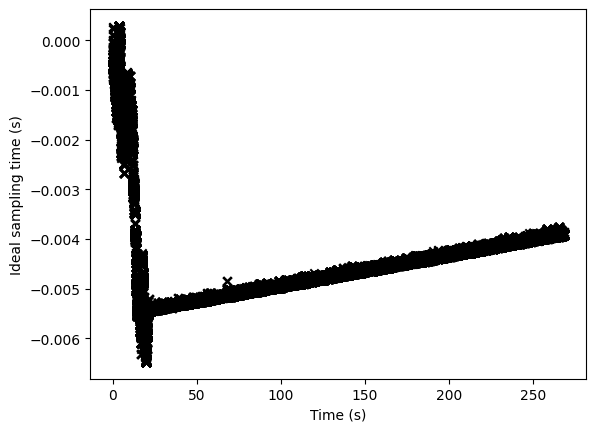

In [5]:
# Plot the tau_s
plt.figure()
tau_time_stamps = time[::int(samples_per_symbol)][:-2]
plt.scatter(tau_time_stamps, tau_s, marker='x', color='black')
plt.ylabel('Ideal sampling time (s)')
plt.xlabel('Time (s)')

In [6]:
# Apply the heuristic tau's
decision_values = []
symbol_duration = 1 / symbol_rate
for i, tau in enumerate(tau_s):
    tau_sample_offset = int(samples_per_symbol * (tau / symbol_duration) + 0.5 * samples_per_symbol * symbols_to_average)
    begin_sample = int((i+2) * samples_per_symbol) + tau_sample_offset
    end_sample = int((i+3) * samples_per_symbol) + tau_sample_offset
    window = demodulated_data[begin_sample:end_sample]
    decision_values.append(np.sum(window) / len(window))

bits = np.greater(decision_values, np.zeros_like(decision_values))

/var/folders/q_/j0nfhbld0vbcnzffn6594bzh0000gn/T/ipykernel_26217/3951007782.py:9: RuntimeWarning: invalid value encountered in scalar divide
  decision_values.append(np.sum(window) / len(window))


0/1000 errors found in clip index i=50/86400
TX Data Length: 86400008
RX Data Length: 268434
Clean data found from RX 24s (i=24399) to 55s (i=55399), for a total length 31s
	TX data indexes from 50s to 81s
Errors in the first clip range 0
Errors in the last clip range 51, (RX i = 55399 to 56399)
Bit Error Rate (BER): 0.0
Total Sensed Clips 31

[0 0 1 1 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0
 1 1 1]
[0 0 1 1 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0
 1 1 1]


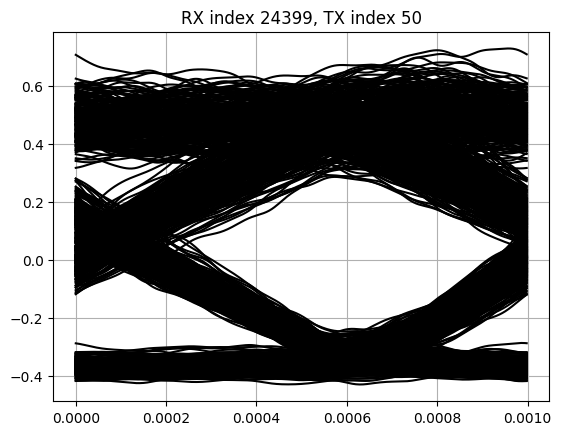

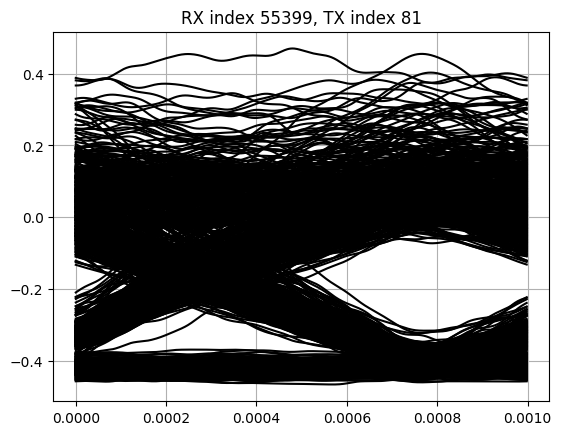

8/1000 errors found in clip index i=84/8640000
TX Data Length: 86400008
RX Data Length: 268434
Clean data found from RX 58s (i=58399) to 59s (i=59399), for a total length 1s
	TX data indexes from 84s to 85s
Errors in the first clip range 8
Errors in the last clip range 30, (RX i = 59399 to 60399)
Bit Error Rate (BER): 0.008
Total Sensed Clips 1

[0 0 0 1 1 0 1 1 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 1
 0 0 1]
[0 0 0 1 1 0 1 1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 1 1 1
 0 0 1]


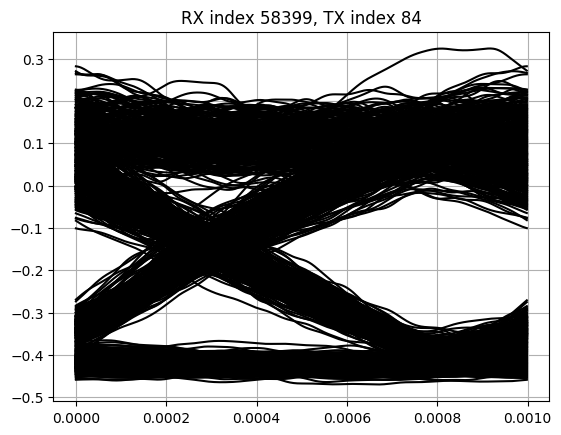

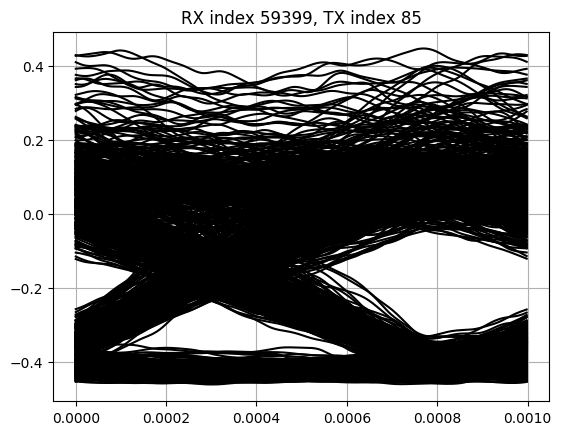

0/1000 errors found in clip index i=86/864000
TX Data Length: 86400008
RX Data Length: 268434
Clean data found from RX 60s (i=60399) to 67s (i=67399), for a total length 7s
	TX data indexes from 86s to 93s
Errors in the first clip range 0
Errors in the last clip range 197, (RX i = 67399 to 68399)
Bit Error Rate (BER): 0.0
Total Sensed Clips 7

[1 1 1 1 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 1 0 1 0 0 0 1
 0 1 0]
[1 1 1 1 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 1 0 1 0 0 0 1
 0 1 0]


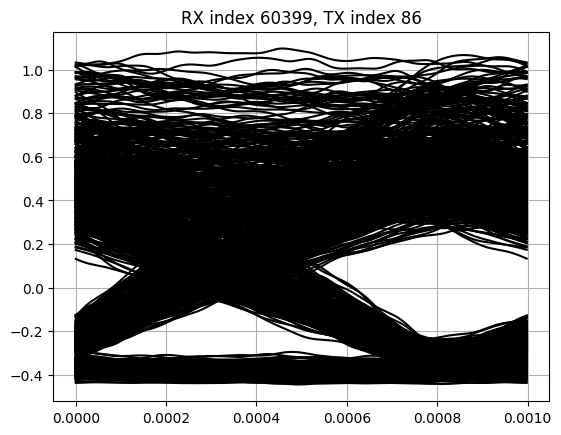

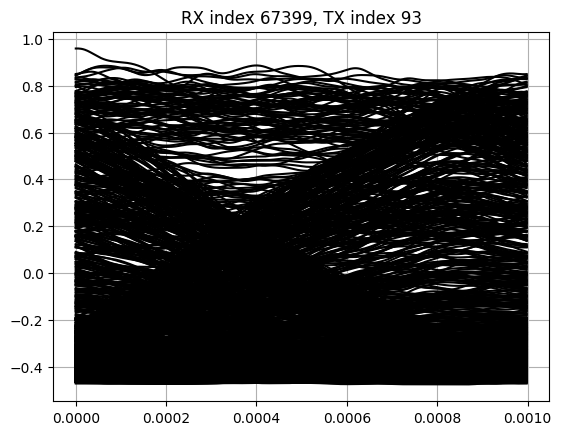

9/1000 errors found in clip index i=96/8640000
TX Data Length: 86400008
RX Data Length: 268434
Clean data found from RX 70s (i=70399) to 94s (i=94399), for a total length 24s
	TX data indexes from 96s to 120s
Errors in the first clip range 9
Errors in the last clip range 11, (RX i = 94399 to 95399)
Bit Error Rate (BER): 0.000375
Total Sensed Clips 24

[1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 0
 1 1 0]
[1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 0
 1 1 0]


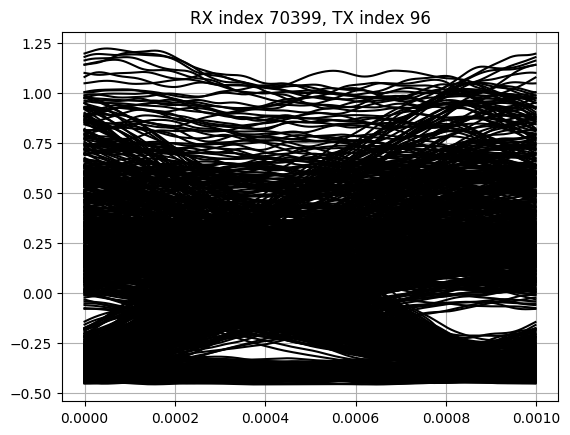

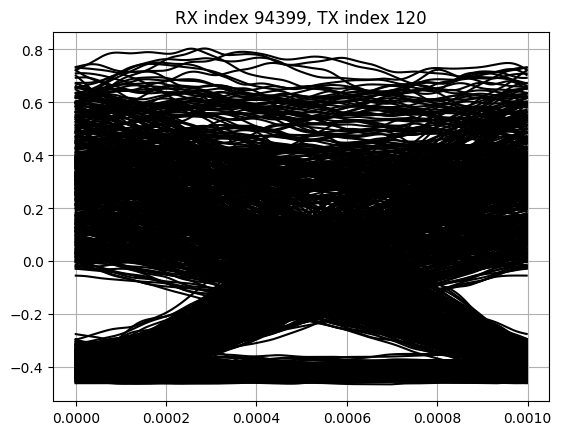

0/1000 errors found in clip index i=121/864000
TX Data Length: 86400008
RX Data Length: 268434
Clean data found from RX 95s (i=95399) to 128s (i=128399), for a total length 33s
	TX data indexes from 121s to 154s
Errors in the first clip range 0
Errors in the last clip range 182, (RX i = 128399 to 129399)
Bit Error Rate (BER): 0.0
Total Sensed Clips 33

[1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1
 1 1 0]
[1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1
 1 1 0]


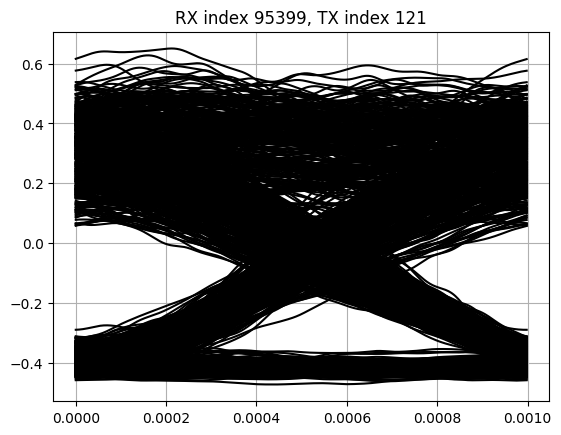

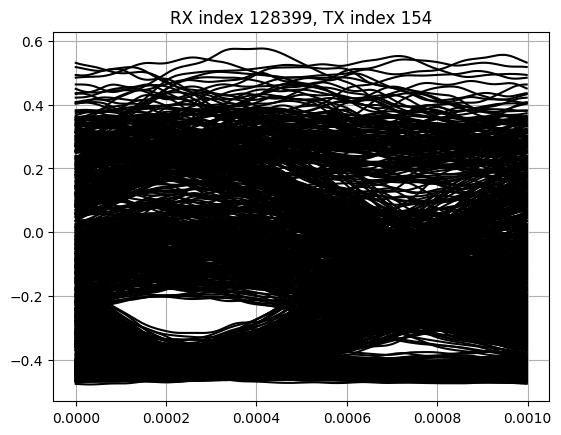

0/1000 errors found in clip index i=155/8640000
TX Data Length: 86400008
RX Data Length: 268434
Clean data found from RX 129s (i=129399) to 130s (i=130399), for a total length 1s
	TX data indexes from 155s to 156s
Errors in the first clip range 0
Errors in the last clip range 74, (RX i = 130399 to 131399)
Bit Error Rate (BER): 0.0
Total Sensed Clips 1

[0 1 0 0 0 1 1 1 0 1 0 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1
 1 1 0]
[0 1 0 0 0 1 1 1 0 1 0 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1
 1 1 0]


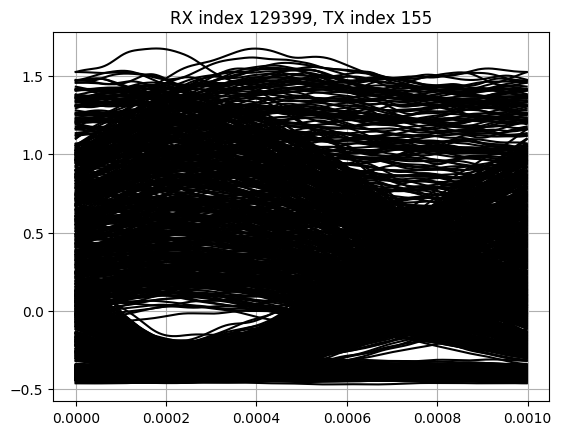

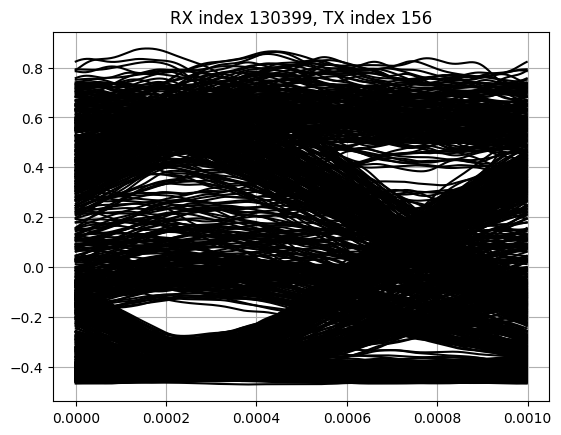

0/1000 errors found in clip index i=157/864000
TX Data Length: 86400008
RX Data Length: 268434
Clean data found from RX 131s (i=131399) to 132s (i=132399), for a total length 1s
	TX data indexes from 157s to 158s
Errors in the first clip range 0
Errors in the last clip range 81, (RX i = 132399 to 133399)
Bit Error Rate (BER): 0.0
Total Sensed Clips 1

[0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1 0
 1 0 0]
[0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1 0
 1 0 0]


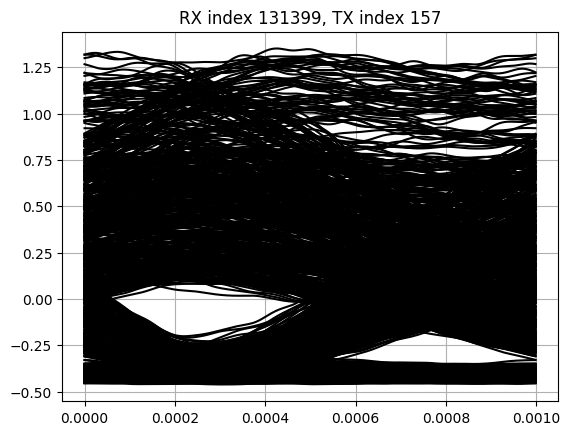

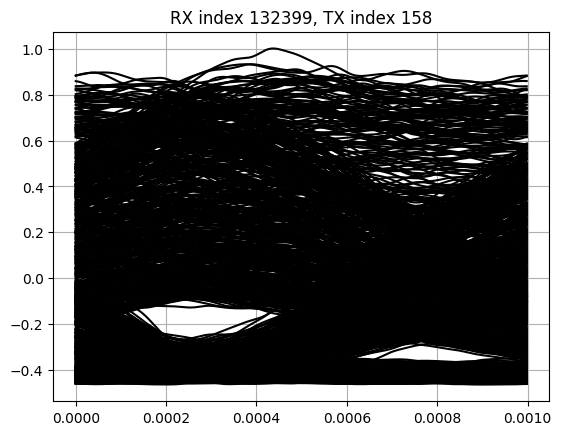

0/1000 errors found in clip index i=160/864000
TX Data Length: 86400008
RX Data Length: 268434
Clean data found from RX 134s (i=134399) to 177s (i=177399), for a total length 43s
	TX data indexes from 160s to 203s
Errors in the first clip range 0
Errors in the last clip range 21, (RX i = 177399 to 178399)
Bit Error Rate (BER): 0.0
Total Sensed Clips 43

[1 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1 1 1 1 1 0 0 1 1 0
 1 1 0]
[1 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1 1 1 1 1 0 0 1 1 0
 1 1 0]


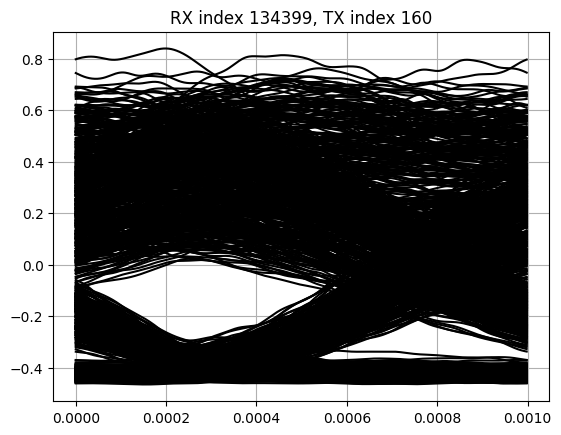

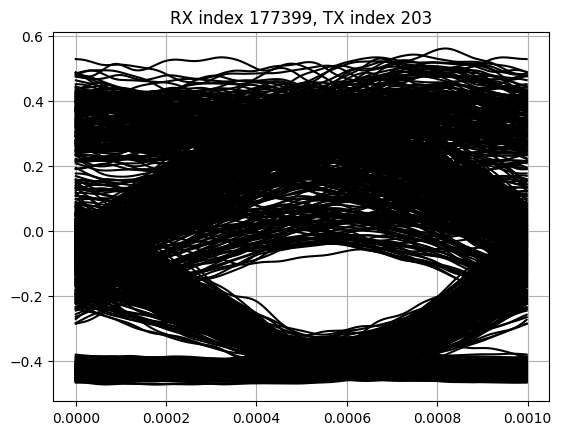

4/1000 errors found in clip index i=204/864000
TX Data Length: 86400008
RX Data Length: 268434
Clean data found from RX 178s (i=178399) to 239s (i=239399), for a total length 61s
	TX data indexes from 204s to 265s
Errors in the first clip range 4
Errors in the last clip range 43, (RX i = 239399 to 240399)
Bit Error Rate (BER): 0.0003278688524590164
Total Sensed Clips 61

[0 1 1 1 1 1 1 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 1 0 0 1 0
 1 1 0]
[0 1 1 1 1 1 1 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 1 0 0 1 0
 1 1 0]


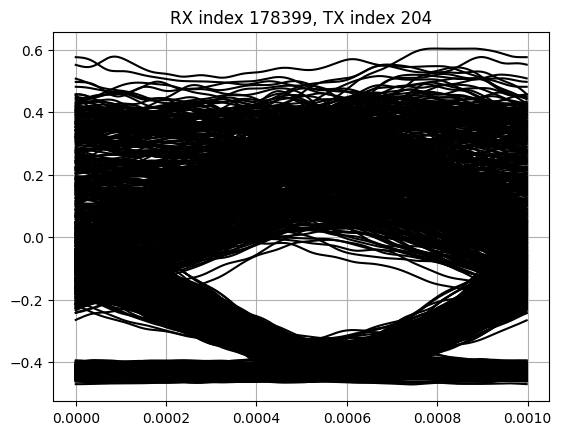

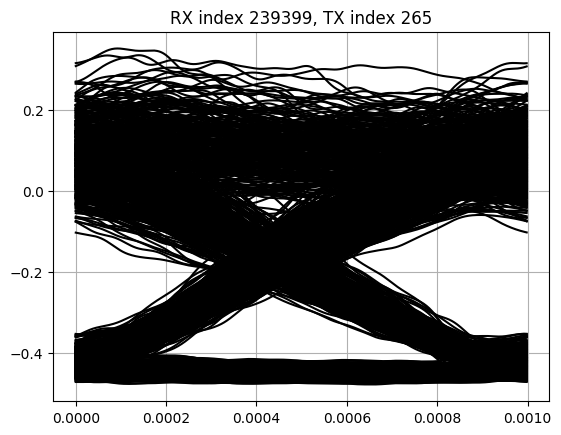

0/1000 errors found in clip index i=266/864000
TX Data Length: 86400008
RX Data Length: 268434
Clean data found from RX 240s (i=240399) to 248s (i=248399), for a total length 8s
	TX data indexes from 266s to 274s
Errors in the first clip range 0
Errors in the last clip range 52, (RX i = 248399 to 249399)
Bit Error Rate (BER): 0.00025
Total Sensed Clips 8

[0 1 1 1 1 0 0 1 0 1 1 1 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0
 1 0 1]
[0 1 1 1 1 0 0 1 0 1 1 1 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0
 1 0 1]


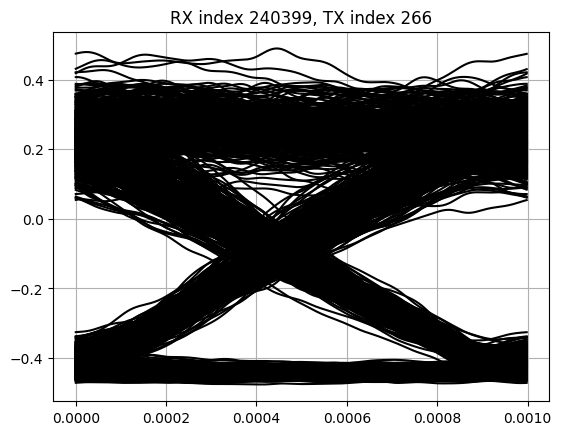

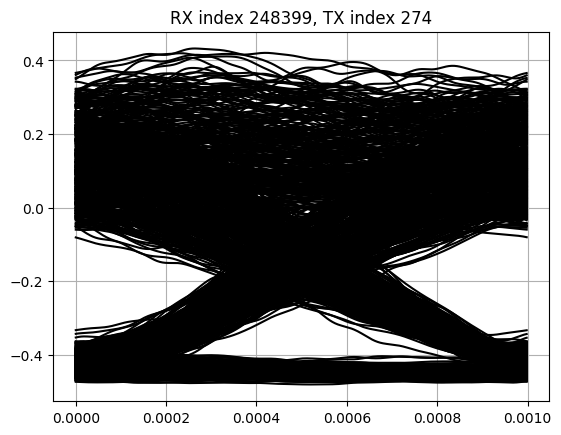

0/1000 errors found in clip index i=275/864000
TX Data Length: 86400008
RX Data Length: 268434
Clean data found from RX 249s (i=249399) to 249s (i=249399), for a total length 0s
	TX data indexes from 275s to 294s
Errors in the first clip range 0
Errors in the last clip range 8, (RX i = 249399 to 250399)
Bit Error Rate (BER): inf
Total Sensed Clips 19

[1 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 1 0
 1 1 0]
[1 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 1 0
 1 1 0]


/var/folders/q_/j0nfhbld0vbcnzffn6594bzh0000gn/T/ipykernel_26217/1961611026.py:98: RuntimeWarning: divide by zero encountered in scalar divide
  bit_error_rate = total_errors / (end_tau - tau_min)


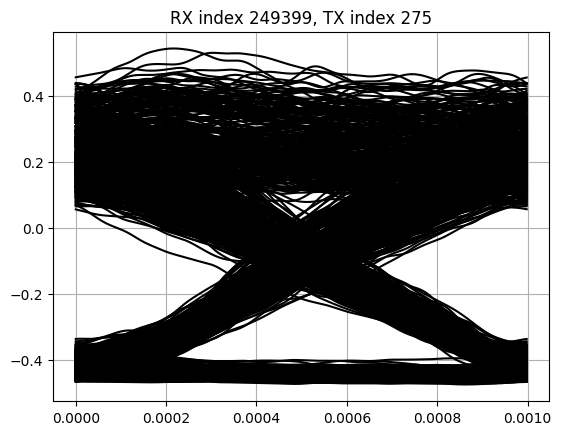

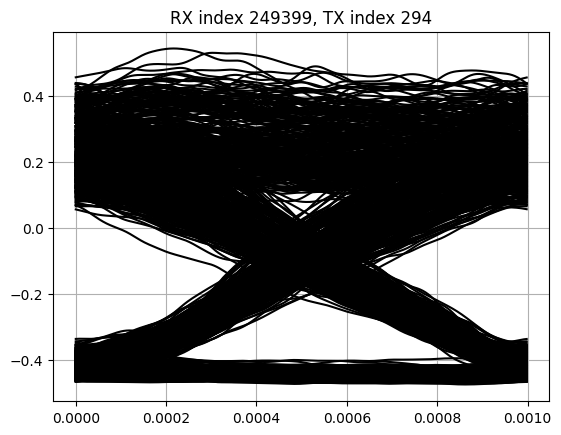

KeyboardInterrupt: 

In [7]:
max_errors_per_clip_range=10
start_tx_index = 50 #s
start_rx_index = 24399 #raw index value which is clip_range * seconds
tries = 100
time = np.arange(len(data)) / sample_rate

with open("tx_data", 'rb') as transmitted_binary:
    transmitted_array = np.asarray(bytearray(transmitted_binary.read()))

transmitted_bits = np.unpackbits(transmitted_array)
received_bits = bits.astype('uint8')

tau_min = 0

clip_range = 1000 # bits
ith_kbit = -1

total_number_of_clips = int(len(transmitted_bits)/clip_range)

for n in range(tries):
    number_of_errors = len(received_bits)
    for i in range(start_tx_index, total_number_of_clips):
        clipped_transmitted_bits = transmitted_bits[i*clip_range:(i+1)*(clip_range)]
        min_number_of_errors_per_i = clip_range
        # Search for the minimum number of errors caused by the start of the data sequence
        for tau in range(start_rx_index, len(received_bits) - len(clipped_transmitted_bits)):
            error_bits = np.abs(np.ndarray.astype(clipped_transmitted_bits, np.byte) \
                - np.ndarray.astype(received_bits[tau:tau+len(clipped_transmitted_bits)], np.byte))
            temp = np.sum(error_bits)
            if temp < min_number_of_errors_per_i:
                min_number_of_errors_per_i = temp

            if temp < number_of_errors:
                number_of_errors = temp
                tau_min = tau

            if temp < max_errors_per_clip_range:
                number_of_errors = temp
                tau_min = tau
                break
        print('{0}/{1}'.format(min_number_of_errors_per_i,clip_range) \
                + ' errors found in clip index i=' + str(i) \
                + '/' + str(total_number_of_clips), end='\r')
        
        if number_of_errors < max_errors_per_clip_range:
            ith_kbit = i
            break

    # Once the first fully correct clip range is found, 
    # look for the last block that has less than max_errors_per_clip_range

    # Update this block to find skip errors, and then keep going
    end_number_of_errors = clip_range
    end_tau = tau_min
    total_errors = 0
    total_sensed_clips = 0
    skip_offset = 0
    tx_offset = i

    length = 100
    skip_search = []
    for j in range(1, length // 2 + 1):
        skip_search.extend([j, -j])

    def estimate_errors(tau):
        clipped_transmitted_bits = transmitted_bits[tx_offset*clip_range:(tx_offset+1)*(clip_range)]
        error_bits = np.abs(np.ndarray.astype(clipped_transmitted_bits, np.byte) \
            - np.ndarray.astype(received_bits[tau:tau+len(clipped_transmitted_bits)], np.byte))
        return np.sum(error_bits)

    for tau in range(tau_min, len(received_bits) - len(clipped_transmitted_bits), clip_range):
        temp = estimate_errors(tau + skip_offset)

        end_number_of_errors = temp
        
        if temp > max_errors_per_clip_range:
            # for skip in skip_search:
            #     temp = estimate_errors(tau + skip)
            #     if temp < max_errors_per_clip_range:
            #         skip_offset = skip
            #         total_errors += temp
            #         display('break')
            #         break
            end_tau = tau
            break
        else:
            total_errors += temp
            total_sensed_clips += 1
        
        tx_offset += 1

    
        

    # min_error_bits = np.abs(np.ndarray.astype(transmitted_bits, np.byte) \
    #         - np.ndarray.astype(received_bits[tau_min:tau_min+len(transmitted_bits)], np.byte))

    bit_error_rate = total_errors / (end_tau - tau_min)

    print()
    print('TX Data Length: ' + str(len(transmitted_bits)))
    print('RX Data Length: ' + str(len(received_bits)))
    print(f'Clean data found from RX {tau_min//1000}s (i={tau_min}) to {end_tau//1000}s (i={end_tau}), for a total length {(end_tau - tau_min) // 1000}s')
    print(f'\tTX data indexes from {i}s to {tx_offset}s')
    print('Errors in the first clip range {0}'.format(number_of_errors))
    print(f'Errors in the last clip range {end_number_of_errors}, (RX i = {end_tau} to {end_tau + len(clipped_transmitted_bits)})')
    print('Bit Error Rate (BER): ' + str(bit_error_rate))
    print(f'Total Sensed Clips {total_sensed_clips}')
    print()
    print(str(received_bits[tau_min:tau_min+40]))
    print(str(transmitted_bits[ith_kbit*clip_range:ith_kbit*clip_range+40]))

    plt.figure()
    plt.title(f'RX index {tau_min}, TX index {i}')
    for i in range(1000):
        start_time = i * symbol_duration 
        end_time = (i + 1) * symbol_duration
        start_sample = int(start_time * sample_rate + sample_rate * tau_min / 1000) 
        end_sample = int(end_time * sample_rate + sample_rate * tau_min / 1000)

        # plt.plot(time[start_sample:end_sample] - time[start_sample], 
        #     demodulated_data[start_sample:end_sample], color='red')
        plt.plot(time[start_sample:end_sample] - time[start_sample], 
            sliding_window_average[start_sample:end_sample], color='black')

        #ax.set_title(f'Interval {i + 1}: {start_time} - {end_time} seconds')
        plt.grid(True)
        #plt.ylim(-0.5, 0.5)
    plt.show()

    plt.figure()
    plt.title(f'RX index {end_tau}, TX index {tx_offset}')
    for i in range(1000):
        start_time = i * symbol_duration 
        end_time = (i + 1) * symbol_duration
        start_sample = int(start_time * sample_rate + sample_rate * end_tau / 1000) 
        end_sample = int(end_time * sample_rate + sample_rate * end_tau / 1000)

        # plt.plot(time[start_sample:end_sample] - time[start_sample], 
        #     demodulated_data[start_sample:end_sample], color='red')
        plt.plot(time[start_sample:end_sample] - time[start_sample], 
            sliding_window_average[start_sample:end_sample], color='black')

        #ax.set_title(f'Interval {i + 1}: {start_time} - {end_time} seconds')
        plt.grid(True)
        #plt.ylim(-0.5, 0.5)
    plt.show()
    start_rx_index = end_tau
    start_tx_index = tx_offset

In [ ]:
derivative_range = np.max(derivative_sliding_window_average) - np.min(derivative_sliding_window_average)

KeyboardInterrupt: 